# Objective

Develop an agent-based model to simulate pandemic spread dynamics and explore the impact of intervention strategies, such as social distancing, on infection rates and recovery.

---

## A. Building the Base Model: Infection Dynamics in a Population

### 1. Define the Environment and Initial Conditions

- Create a 75 × 75 voxel grid representing a bounded area where individuals (agents) can move and interact.
- Populate the grid with 100 agents, initialized randomly in the following states:

    - 95 agents: Susceptible (S) — individuals at risk of infection.  
    - 5 agents: Infected (I) — individuals who can transmit the infection.  
    - 0 agents: Recovered (R) — individuals who have recovered and are immune.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [52]:
seed = 1024, 
grid_w = 75, 
N = 100, 
size = 5
def initialize(seed = 1024, grid_w = 75, N = 100, size = 5):
    np.random.seed(seed)

    # initialize and set susceptible people
    states = np.zeros(N, dtype = int)
    # set infected people
    infected_indices = np.random.choice(N, size=size, replace=False)
    states[infected_indices] = 1

    # initialize their position on the grid.
    positions = np.random.randint(0, grid_w, size = (N, 2))

    return states, positions

states, positions = initialize()
print('S', np.sum(states == 0))
print('I', np.sum(states == 1))
print(positions[:5])

S 95
I 5
[[31 42]
 [12 67]
 [48 66]
 [62 64]
 [56 14]]


### 2. Define Agent Behaviors

- Movement: Each agent moves to a neighboring cell each time step (up, down, left, right, or stays in place). Movement can be random or follow simple rules, e.g., random walk (Brownian motion) or Levy walk.
- Transmission: If a susceptible agent shares a cell with an infected agent, there is a probability $p$ that the susceptible agent becomes infected.
- Recovery: Infected agents have a probability q of recovering at each time step, after which they transition to the recovered state.

In [53]:
def movement(positions, grid_w = 75, grid_h = 75):
    directions = np.array([[0,-1],[0,1],[-1,0],[1,0], [0,0]]) # left, right, up, down, stay
    movement_indices = np.random.randint(0, 5, size = len(positions))
    moves = directions[movement_indices]
    positions = positions + moves

    # keep agents within grid bounds (clip to [0, 74])
    positions[:, 0] = np.clip(positions[:, 0], 0, grid_w - 1)
    positions[:, 1] = np.clip(positions[:, 1], 0, grid_h - 1)

    return positions

print('before', positions[:5])
print('after', movement(positions)[:5])

before [[31 42]
 [12 67]
 [48 66]
 [62 64]
 [56 14]]
after [[31 43]
 [12 67]
 [49 66]
 [61 64]
 [55 14]]


In [54]:
def transmission(positions, states, p):
    res_states = states.copy()
    # find out who are in the same cell
    unique_cells, inverse_indices = np.unique(positions, axis=0, return_inverse=True)
    #print(unique_cells[:10], inverse_indices[:10])
    # inverse_indices maps each position to its unique cell’s index
    for i in range(len(unique_cells)):
        shared_cell_indices = np.where(i == inverse_indices)[0]
        shared_cell_states = states[shared_cell_indices]
        # infection
        if np.any(shared_cell_states == 1) and np.any(shared_cell_states == 0):
            s_cell_indices = shared_cell_indices[shared_cell_states == 0]
            i_or_not = np.random.rand(len(s_cell_indices)) < p # True = get infected
            res_states[s_cell_indices[i_or_not]] = 1
    return res_states

print('before', states)
print('after', transmission(positions, states, p = 0.5))

before [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
after [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [55]:
def recovery(positions, states, q):
    res_states = states.copy()
    infected_agents_indices = np.where(states == 1)[0]
    r_or_not = np.random.rand(len(infected_agents_indices)) < q
    recovered_indices = infected_agents_indices[r_or_not]
    res_states[recovered_indices] = 2
    return res_states

print('before', states)
print('after', recovery(positions, states, q = 0.5))

before [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
after [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


### 3. Run the Simulation

- Simulate the model over 200 time steps, recording the population counts in each compartment (susceptible, infected, recovered ) at each step.
-  Plot the number of agents in each state over time to visualize infection spread, recovery, and eventual immunity.

In [77]:
states, positions = initialize(seed=111, grid_w=75, N=50, size=5)

def pop_count(states):
    s = len(np.where(states == 0)[0])
    i = len(np.where(states == 1)[0])
    r = len(np.where(states == 2)[0])
    res = [s, i, r]
    return res

def simulate(states, positions, p = 0.5, q = 0.01, grid_w = 75, grid_h = 75):
    pop_counts = []
    pop_counts.append(pop_count(states))
    for i in range(200):
        positions = movement(positions, grid_w = grid_w, grid_h = grid_h)                         
        states = transmission(positions, states, p)
        states = recovery(positions, states, q) 

        pop_counts.append(pop_count(states))
    res = np.array(pop_counts)
    return res

pop_counts = simulate(states, positions)

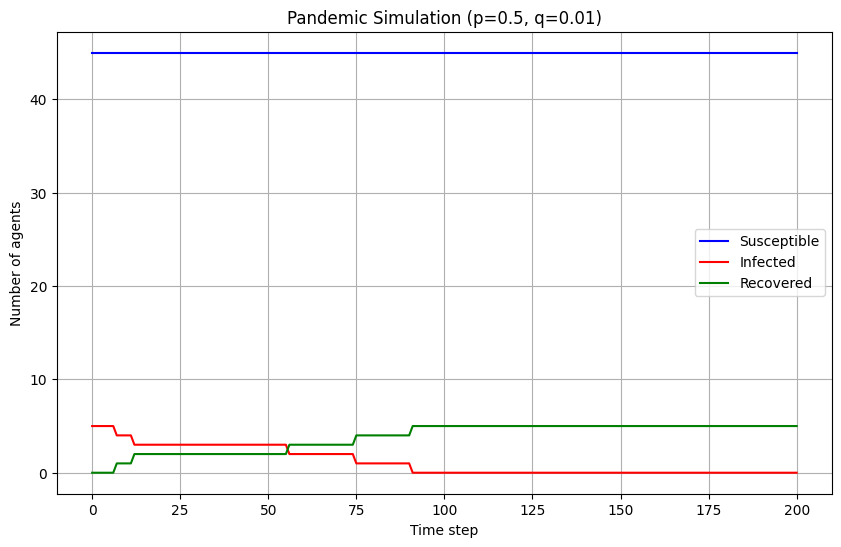

In [ ]:
def plot(pop_counts, p = 0.5, q = 0.01):
    time_steps = np.arange(len(pop_counts))

    plt.figure(figsize=(10,6))
    plt.plot(time_steps, pop_counts[:, 0], label='Susceptible', color='blue')
    plt.plot(time_steps, pop_counts[:, 1], label='Infected', color='red')
    plt.plot(time_steps, pop_counts[:, 2], label='Recovered', color='green')

    plt.xlabel('Time step')
    plt.ylabel('Number of agents')
    plt.title(f"Pandemic Simulation (p={p}, q={q})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot(pop_counts)

### 4. Sensitivity Analysis

- Test different values of p (infection probability) and q (recovery probability). For instance, run simulations with p= 0.05,0.1 and q= 0.02,0.05.
- Analyze how changes in pand qimpact infection peaks, time to infection peak, and overall population recovery.
- Rerun the simulation with other random initial conditions. Compare the plots across different runs and plot the average of each population subgroup over time. Do you see some average trend across the random initial conditions?

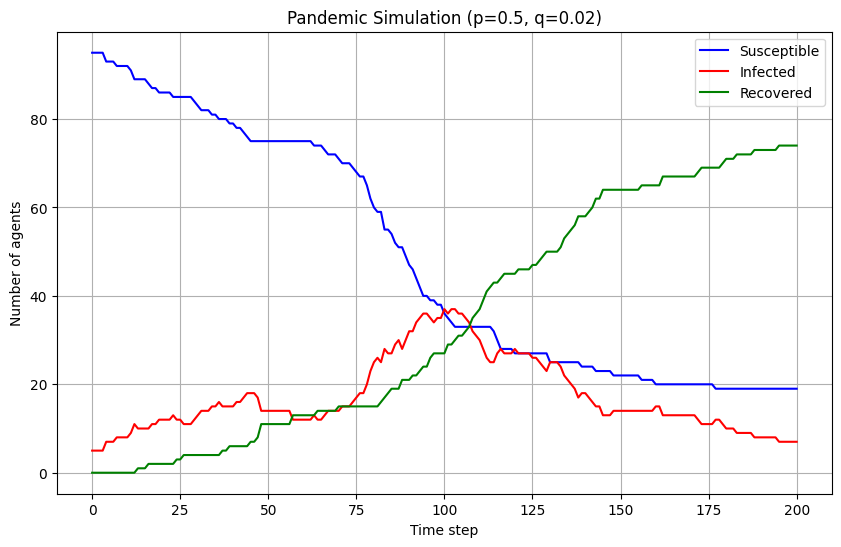

In [79]:
states, positions = initialize(seed=111, grid_w=grid_w, N=100, size=5)
res1 = simulate(states, positions, p = 0.5, q = 0.02)
plot(res1, p = 0.5, q = 0.02)

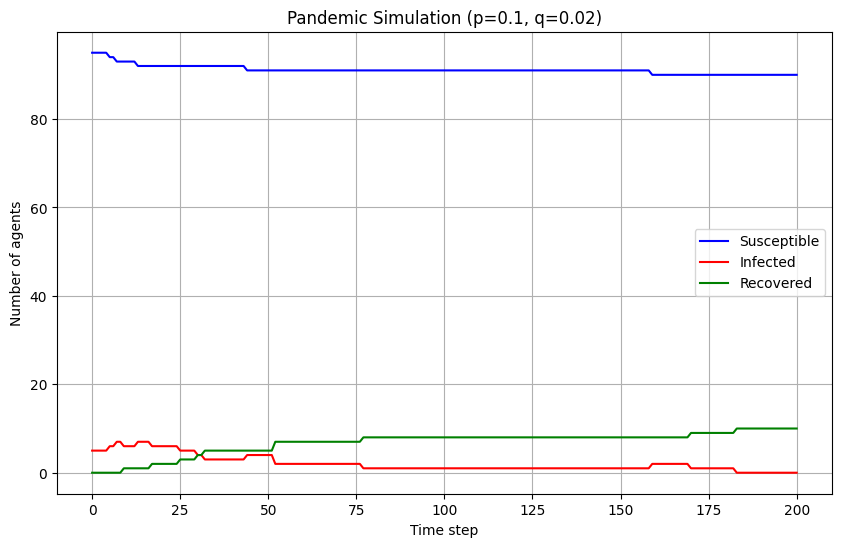

In [80]:
states, positions = initialize(seed=111, grid_w=grid_w, N=100, size=5)
res2 = simulate(states, positions, p = 0.1, q = 0.02)
plot(res2, p = 0.1, q = 0.02)

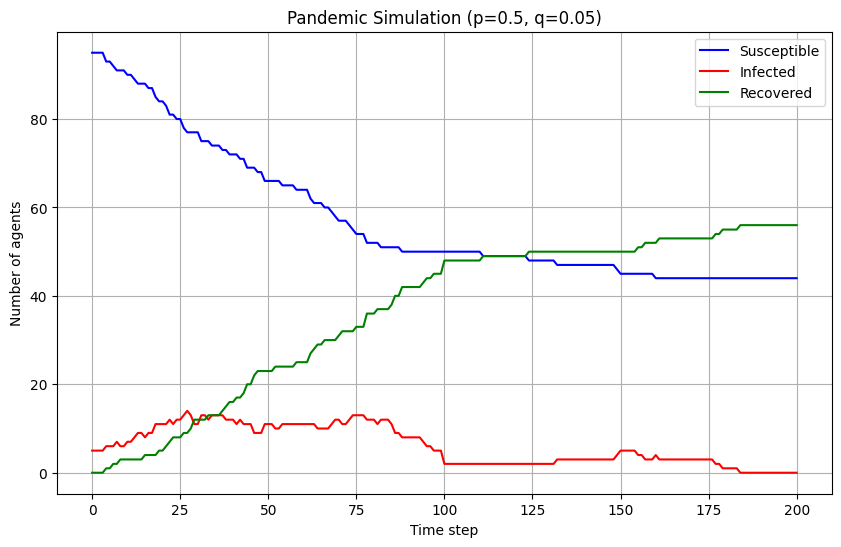

In [81]:
states, positions = initialize(seed=111, grid_w=grid_w, N=100, size=5)
res3 = simulate(states, positions, p = 0.5, q = 0.05)
plot(res3, p = 0.5, q = 0.05)

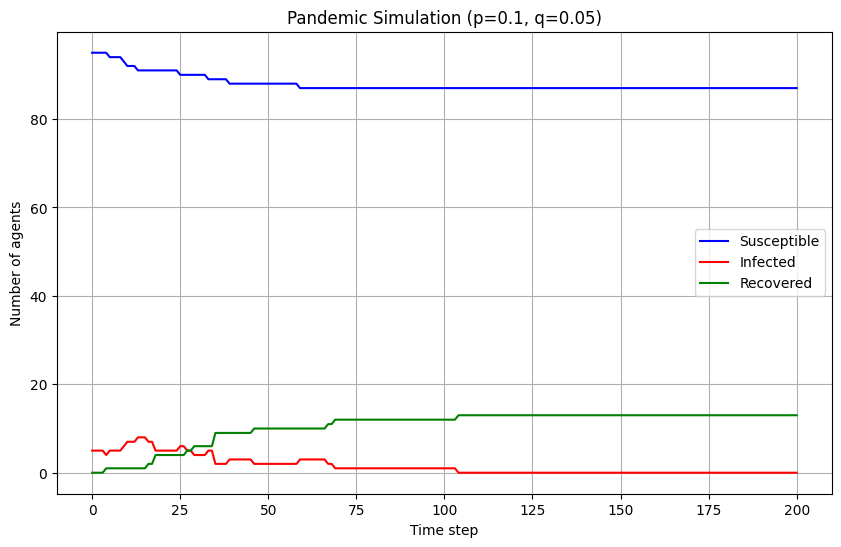

In [82]:
states, positions = initialize(seed=111, grid_w=grid_w, N=100, size=5)
res4 = simulate(states, positions, p = 0.1, q = 0.05)
plot(res4, p = 0.1, q = 0.05)

#### Summarize parameter sensitivity analysis in comparing p and q

In Fig 1, p=0.5 and q=0.02. The peak is high, reaching its infection peak at approximately 36 infected agents in 100 time steps. With low recovery probability q, individuals stay sick for a long time. The recovered cover grows slower than the infected curve till 100 time steps, and the susceptible population drops significnatly. 

In Fig 2, p=0.1 and q=0.02. The infection peak is very low, peaking aroung 7 agents in 15 time steps. Because of the low recovery probability, the infected population didn't drop to zero until 180 time steps, and the recovered population only increased by a small amount. Most people stay susceptible throughout the whole experiment. 

In Fig 3, p=0.5 and q=0.05. The infection peak is moderate, peaking aroung 17 agents in 27 time steps. With high infection rate and high recovery rate, infected individuals recover much faster, leading to a much smaller and earlier infection peak compared to Fig 1. The slope for recovered curve is much steeper and leaves a higher number of susceptible population.

In Fig 4, p=0.1 and q=0.05. The infection peak is also very low, peaking aroung 10 agents in 15 time steps. Similar to Fig 2, the infection rate is too low to spread the disease. With a high recovery rate, the infection drops to zero quickly, and most people remain susceptible. 

In [150]:
num_runs = 10  # number of simulations
seeds = np.arange(100, 100 + num_runs)

def run_10_simulation(seeds, grid_w, N, size, p = 0.5, q = 0.02):
    all_runs = []
    for seed in seeds:
        states, positions = initialize(seed=seed, grid_w=grid_w, N=N, size=size)
        pop_counts = simulate(states, positions, p=p, q=q, grid_w=grid_w)
        all_runs.append(pop_counts)

    all_runs = np.array(all_runs)

    return all_runs

def plot_10_simulation(all_runs, title):
    mean_pop = np.mean(all_runs, axis=0)
    std_pop = np.std(all_runs, axis=0)

    time_steps = np.arange(mean_pop.shape[0])

    plt.figure(figsize=(10,6))

    # plot mean trends
    plt.plot(time_steps, mean_pop[:, 0], color='blue', label='Susceptible (avg)')
    plt.plot(time_steps, mean_pop[:, 1], color='red', label='Infected (avg)')
    plt.plot(time_steps, mean_pop[:, 2], color='green', label='Recovered (avg)')

    # Additional, add shading
    plt.fill_between(time_steps, mean_pop[:,0]-std_pop[:,0], mean_pop[:,0]+std_pop[:,0],
                    color='red', alpha=0.1)
    plt.fill_between(time_steps, mean_pop[:,1]-std_pop[:,1], mean_pop[:,1]+std_pop[:,1],
                    color='red', alpha=0.1)
    plt.fill_between(time_steps, mean_pop[:,2]-std_pop[:,2], mean_pop[:,2]+std_pop[:,2],
                    color='red', alpha=0.1)

    plt.xlabel('Time step')
    plt.ylabel('Number of agents')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

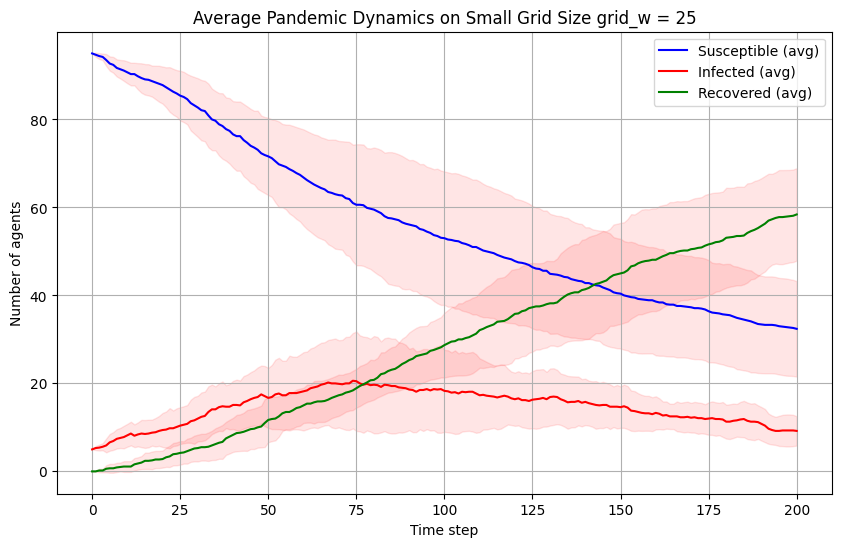

In [151]:
all_runs = run_10_simulation(seeds, grid_w = 25, N = 100, size = 5)
plot_10_simulation(all_runs, 'Average Pandemic Dynamics on Small Grid Size grid_w = 25')

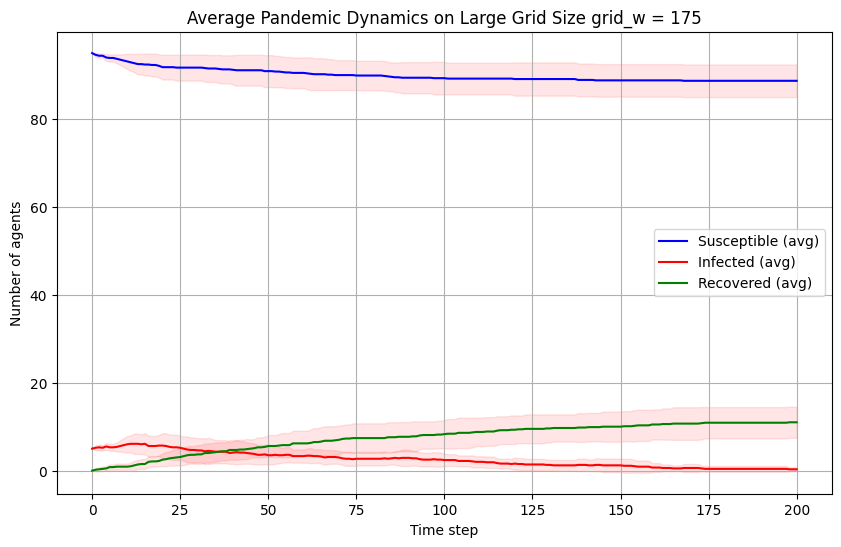

In [112]:
all_runs = run_10_simulation(seeds, grid_w = 175, N = 100, size = 5)
plot_10_simulation(all_runs, 'Average Pandemic Dynamics on Large Grid Size grid_w = 175')

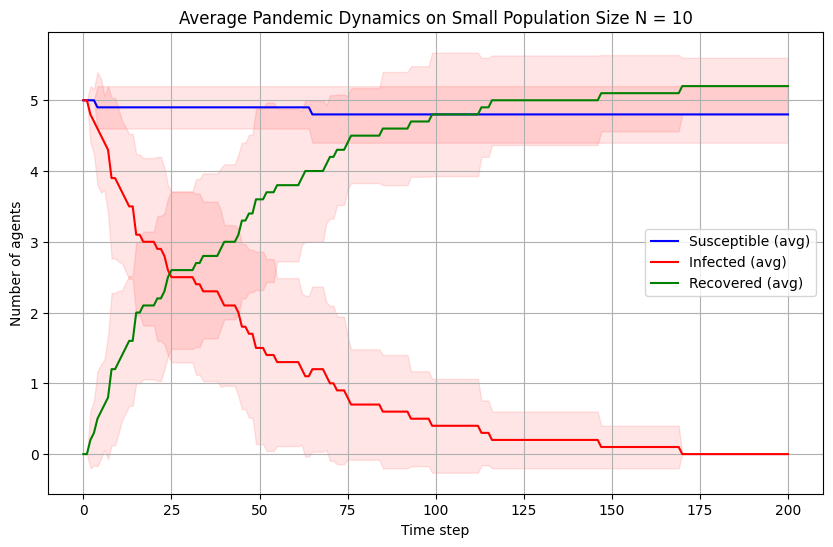

In [113]:
all_runs = run_10_simulation(seeds, grid_w = 75, N = 10, size = 5)
plot_10_simulation(all_runs, 'Average Pandemic Dynamics on Small Population Size N = 10')

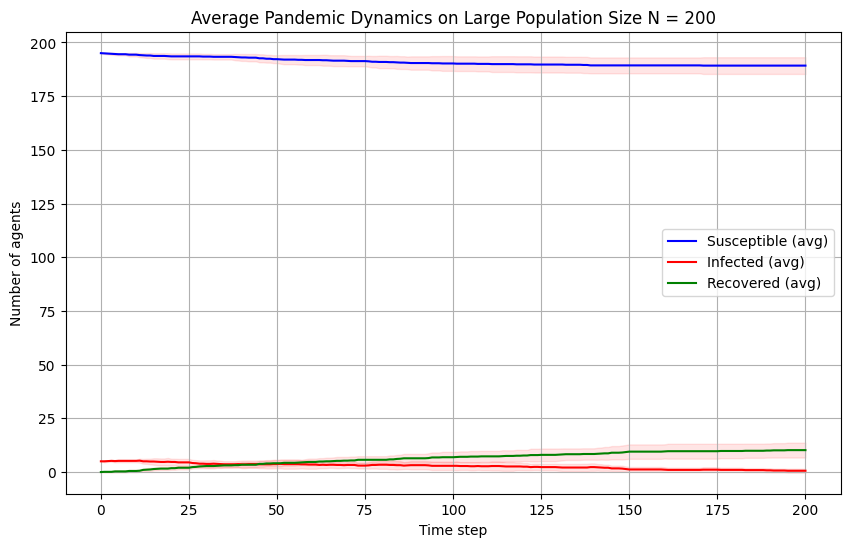

In [115]:
all_runs = run_10_simulation(seeds, grid_w = 75, N = 200, size = 5)
plot_10_simulation(all_runs, 'Average Pandemic Dynamics on Large Population Size N = 200')

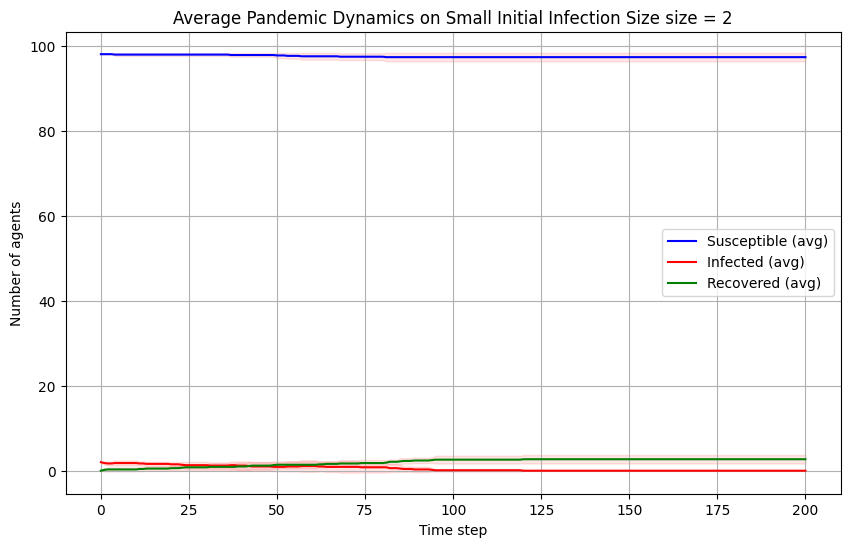

In [121]:
all_runs = run_10_simulation(seeds, grid_w = 75, N = 100, size = 2)
plot_10_simulation(all_runs, 'Average Pandemic Dynamics on Small Initial Infection Size size = 2')

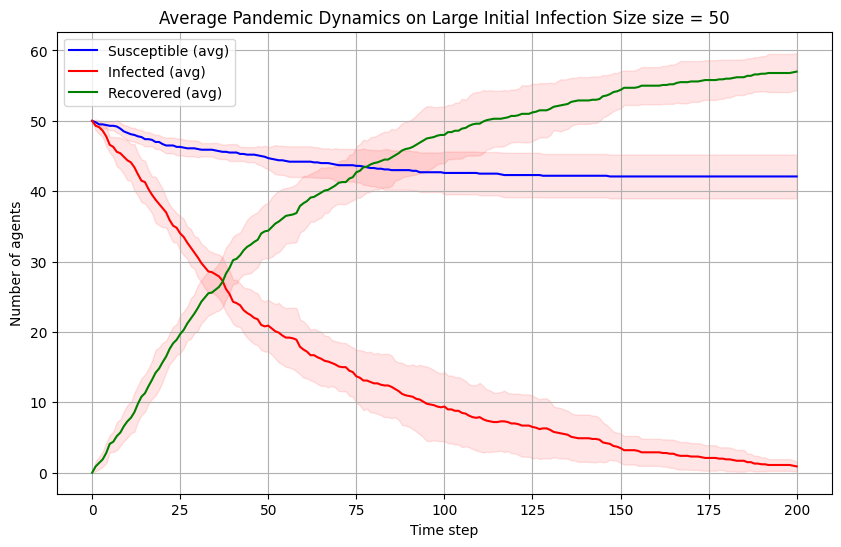

In [120]:
all_runs = run_10_simulation(seeds, grid_w = 75, N = 100, size = 50)
plot_10_simulation(all_runs, 'Average Pandemic Dynamics on Large Initial Infection Size size = 50')

#### Summarize parameter sensitivity analysis in comparing different initialization parameters
- To compare different grid size, which is a proxy for population density:

Fig 5 (Small Grid Size = 25): In the simulation with a small grid size (grid_w = 25), the high population density facilitates a major outbreak. The infection curve shows a significant peak, rising to approximately 20 agents around time step 75. This strong spread leads to a substantial decline in the susceptible population, which drops from ~95 to below 40 agents by the end of the simulation.

Fig 6 (Large Grid Size = 175): In the simulation with a large grid size (grid_w = 175), the low population density stifles the pandemic. The infection peak is very low, reaching only ~6 agents around time step 25 before quickly declining. The low probability of agent interaction prevents sustained transmission. Consequently, the infection dies out, and the vast majority of the population remains susceptible.

- To compare different population size:

Fig 7 (Small Population = 10): In the simulation with a small total population (N = 10, starting with 5 infected), the dynamics are rapid. The infection peak is its starting value of 5 agents, which then rapidly drops toward zero. With such a small pool of agents, the susceptible population remains almost unchanged, while the recovered curve rises quickly to 5, reflecting the recovery of the initial infected group.

Fig 8 (Large Population = 200): In the simulation with a large total population (N = 200, starting with ~5 infected), the infection fails to gain traction. Despite a large susceptible pool (~195 agents), the proportion of initial infectors is too small to initiate a widespread outbreak. The infection peak is extremely low, barely rising from 5 to 9 agents, and the susceptible population remains almost entirely untouched.

- To compare different initial infection population size:

Fig 9 (Small Initial Infection = 2): In the simulation with a small initial infection size (2 agents), the infection fails to launch. The infected peak is negligible, hovering near the starting value of 2 agents before declining. With such a small initial seed, the virus likely dies out before significant transmission can occur. As a result, the recovered population remains near zero, and the susceptible population is almost entirely unaffected.

Fig 10 (Large Initial Infection = 50): In the simulation with a large initial infection size (50 agents), the pandemic begins at its peak. The infected curve starts at 50 and immediately declines as agents recover, showing no initial growth phase. The recovered curve rises steeply, surpassing the infected curve around time step 40. This large initial outbreak burns through a portion of the population, causing the susceptible curve to drop from 50 to ~42 agents.


## B. Extending the Model: Social Distancing and Intervention Strategies

### 1. Introduce Social Distancing Measures: Modify agent movement behavior to simulate social distancing. 

For instance:

- When agents have a reduced probability of moving at each step, limiting their interactions. Which parameter of the model should be changed to model this?
- When agents actively move away from cells with infected individuals when possible, simulating avoidance behavior. Which parameter of the model should be changed to model this?
- Run the simulation for 200 steps with social distancing measures in place, recording and plotting the average compartment counts across multiple runs (with random initial states) over time as before.
- Which parameter impacts the maximum number of infected subjects at each time window to prevent the healthcare system overwhelm?


In [122]:
def reduced_movement(positions, move_prob = 0.3, grid_w = 75, grid_h = 75):
    directions = np.array([[0,-1],[0,1],[-1,0],[1,0], [0,0]]) # left, right, up, down, stay
    movement_indices = np.random.randint(0, 5, size = len(positions))
    moves = directions[movement_indices]

    mask = np.random.rand(len(moves)) < move_prob
    positions[mask] = positions[mask] + moves[mask]

    # keep agents within grid bounds (clip to [0, 74])
    positions[:, 0] = np.clip(positions[:, 0], 0, grid_w - 1)
    positions[:, 1] = np.clip(positions[:, 1], 0, grid_h - 1)

    return positions

print('before', positions[:5])
print('after', reduced_movement(positions, move_prob = 0.3)[:5])

before [[ 6  1]
 [11 18]
 [17 11]
 [18  5]
 [13  5]]
after [[ 6  1]
 [11 18]
 [17 11]
 [18  5]
 [13  6]]


In [123]:
def avoid_movement(positions, states, move_prob = 0.8, grid_w = 75, grid_h = 75):
    infected_positions = positions[states == 1]
    directions = np.array([[0,1],[0,-1],[1,0],[-1,0],[0,0]])
    if len(infected_positions) == 0:
        movement_indices = np.random.randint(0, len(directions), size=len(positions))
        positions = positions + directions[movement_indices]
    else:
        for i in range(len(positions)):
            if states[i] == 0:
                diffs = positions[i] - infected_positions
                distances = np.linalg.norm(diffs, axis=1)
                closest_infected_indices = np.argmin(distances)
                closest_diffs = diffs[closest_infected_indices]
                if np.random.rand() < move_prob:
                    # move away
                    move_vec = np.sign(closest_diffs)
                else:
                    move_vec = directions[np.random.choice(len(directions))]
                positions[i] = positions[i] + move_vec
    # keep agents within grid bounds (clip to [0, 74])
    positions[:, 0] = np.clip(positions[:, 0], 0, grid_w - 1)
    positions[:, 1] = np.clip(positions[:, 1], 0, grid_h - 1)
    return positions

print('before', positions[:5])
print('after', avoid_movement(positions, states, move_prob = 0.8)[:5])

before [[ 6  1]
 [11 18]
 [17 11]
 [18  5]
 [13  6]]
after [[ 5  1]
 [10 19]
 [17 11]
 [18  5]
 [13  5]]


In [ ]:
grid_h, grid_w = 20, 20
p = 0.9
q = 0.02
states, positions = initialize(seed = 1024, grid_w = grid_w, N = 100, size = 5)

def simulate_reduced(states, positions, p = 0.5, q = 0.01, grid_w = 75, grid_h = 75, move_prob = 0.3):
    pop_counts = []
    for _ in range(200):
        positions = reduced_movement(positions, move_prob = move_prob, grid_w = grid_w, grid_h = grid_h)                         
        states = transmission(positions, states, p)
        states = recovery(positions, states, q) 

        pop_counts.append(pop_count(states))
        res = np.array(pop_counts)
    return res

def simulate_avoid(states, positions, p = 0.5, q = 0.01, grid_w = 75, grid_h = 75, move_prob = 0.3):
    pop_counts = []
    pop_counts.append(pop_count(states))
    for _ in range(200):
        positions = avoid_movement(positions, states, move_prob = move_prob, grid_w = grid_w, grid_h = grid_h)                         
        states = transmission(positions, states, p)
        states = recovery(positions, states, q) 

        pop_counts.append(pop_count(states))
        res = np.array(pop_counts)
    return res

pop_counts_reduced = simulate_reduced(states, positions, p = p, q = q, grid_h = grid_h, grid_w = grid_w, move_prob = 0.3)
pop_counts_avoid = simulate_avoid(states, positions, p = p, q = q, grid_h = grid_h, grid_w = grid_w, move_prob = 0.3)

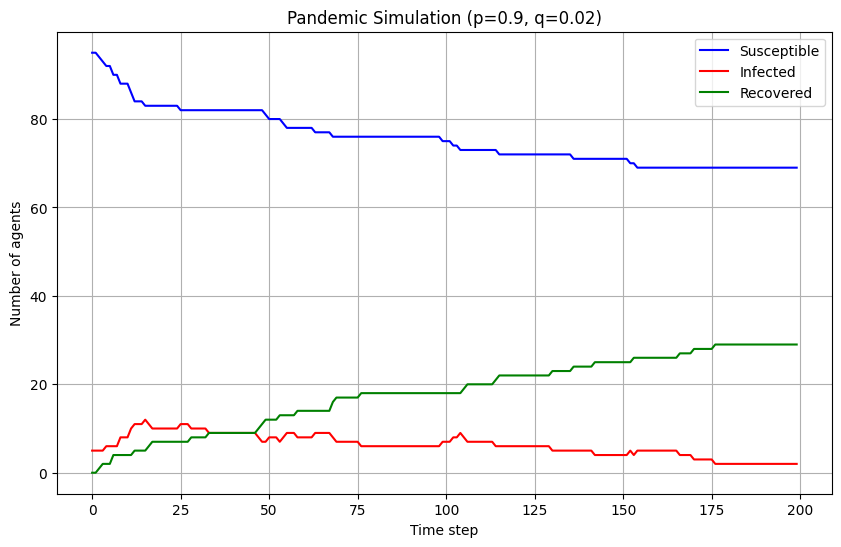

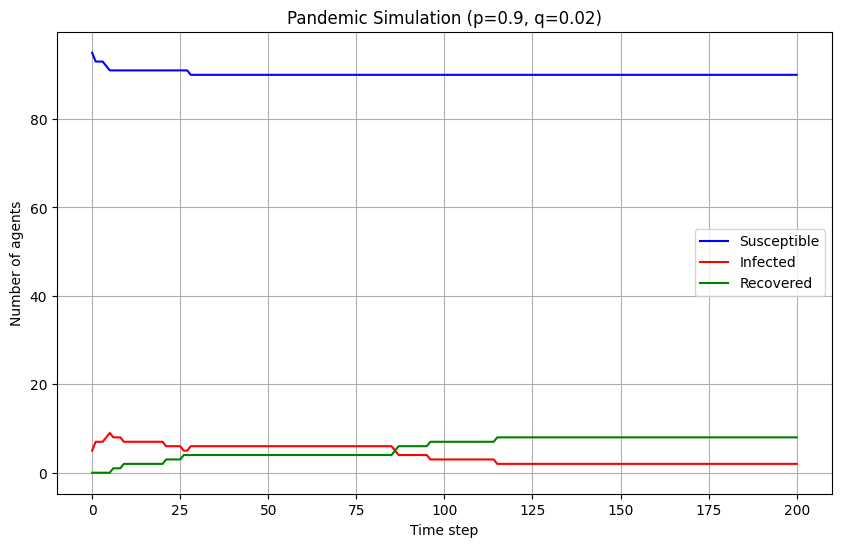

In [142]:
plot(pop_counts_reduced, p = p, q = q)
plot(pop_counts_avoid, p = p, q = q)

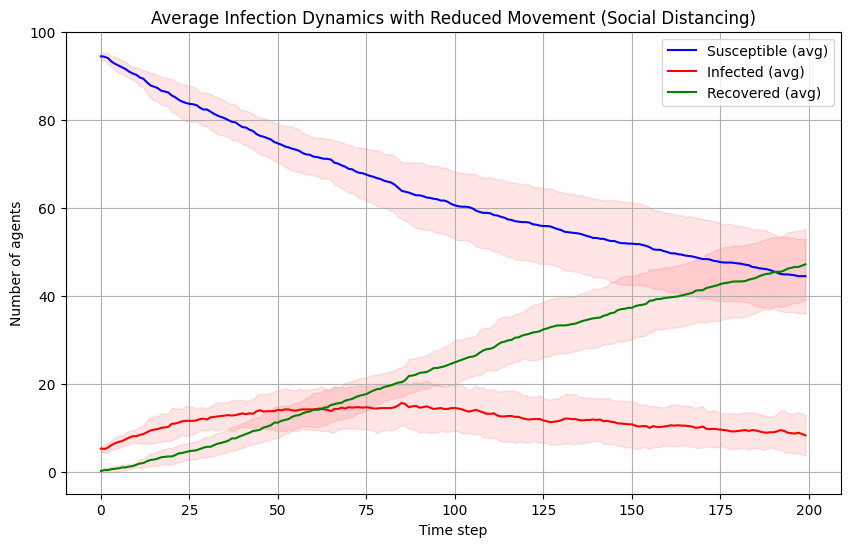

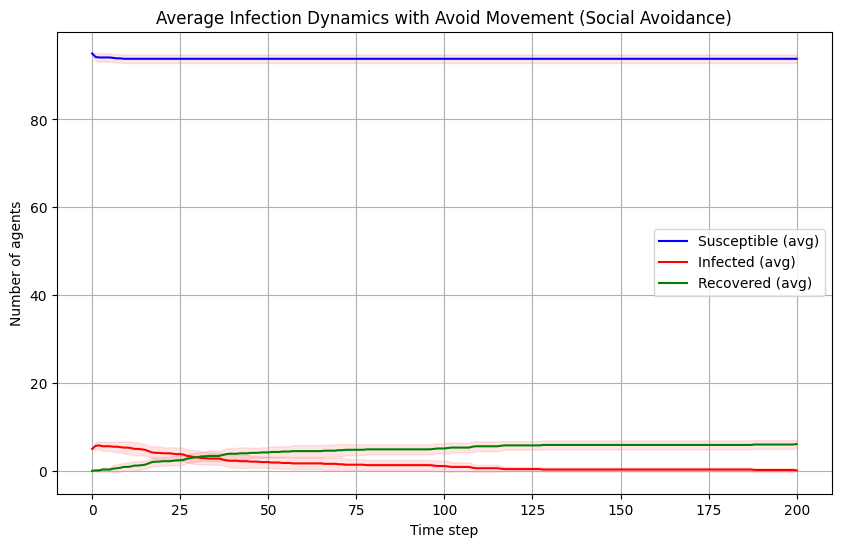

In [ ]:
# run the simulation 10 times
N = 100
grid_h, grid_w = 25, 25
p = 0.9
q = 0.02
size = 5
num_runs = 10
seeds = np.arange(100, 100 + num_runs)

def run_multi_simulation(sim_func, seeds, grid_w, grid_h, N, size, p, q, move_prob):
    all_runs = []
    for seed in seeds:
        states, positions = initialize(seed=seed, grid_w=grid_w, N=N, size=size)
        pop_counts = sim_func(states, positions, p=p, q=q, grid_w=grid_w, grid_h=grid_h, move_prob=move_prob)
        all_runs.append(pop_counts)
    return np.array(all_runs)

all_runs_reduced = run_multi_simulation(simulate_reduced, seeds, grid_w, grid_h, N, size, p, q, move_prob = 0.5)
plot_10_simulation(all_runs_reduced, "Average Infection Dynamics with Reduced Movement (Social Distancing)")

all_runs_avoid = run_multi_simulation(simulate_avoid, seeds, grid_w, grid_h, N, size, p, q, move_prob = 0.5)
plot_10_simulation(all_runs_avoid, "Average Infection Dynamics with Avoid Movement (Social Avoidance)")

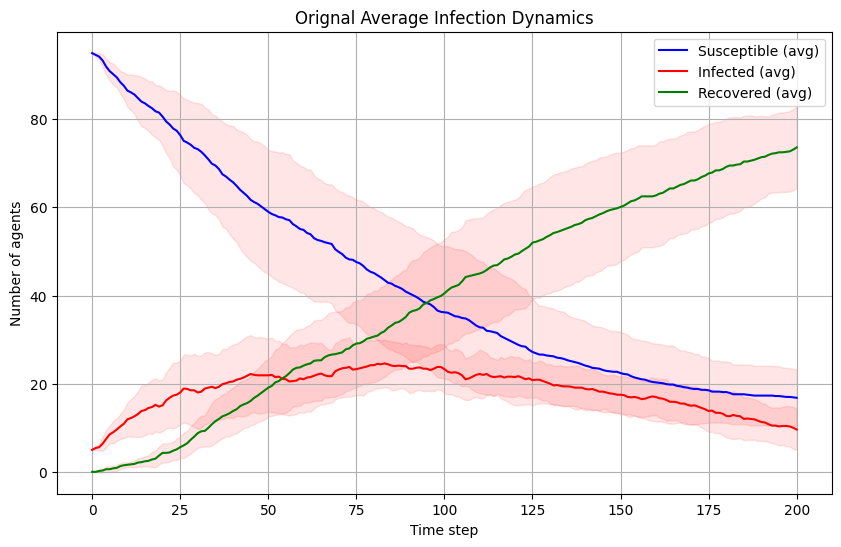

In [160]:
all_runs = run_10_simulation(seeds, grid_w, N, size, p, q)
plot_10_simulation(all_runs, "Orignal Average Infection Dynamics")

### 2. Analyze and Compare Results: Compare the results of the simulations with and without social distancing. 
Focus on metrics such as:
-  The peak number of infected individuals.
- The time it takes for the infection to peak and for the population to reach a stable recovered state.
- Overall infection spread and duration.
- Discuss how social distancing impacts infection rates and the timing of infection peaks, and consider its implications for real-world public health interventions.

Fig 11 (Original Dynamics - No Intervention): In the baseline simulation with no interventions, the infection spreads rapidly and widely. The infected curve shows a significant outbreak, rising from 5 agents to a high peak of approximately 25 infected agents around time step 80. This uncontrolled spread leads to a steep decline in the susceptible population, which falls from ~95 to ~18.

Fig 12 (Reduced Movement - Social Distancing): In the simulation with reduced movement, the curves are flatten. The infection peak is significantly lower, reaching only ~16 agents. The rate of infection is slower, leading to a broader, less severe peak. This intervention successfully slows the pandemic's spread, leaving a much larger susceptible population (~44) at the end of the simulation compared to the baseline.

Fig 13 (Avoid Movement - Social Avoidance): In the simulation with "avoid movement," the intervention is effectively suppresses the outbreak. The infection fails to spread in the population, showing a small peak of ~6 agents before quickly declining to zero by time step 100. The virus is unable to spread. Thus, the susceptible population remains almost entirely unaffected, staying at ~94 agents.

These graphs demonstrate the direct trade-offs of public health interventions. The "Original" scenario (Fig 11) represents an uncontrolled outbreak that would likely overwhelm public health systems. The "Reduced Movement" (Fig 12) shows how social distancing lowers the peak, buying time for healthcare response and reducing the maximum simultaneous burden, even if many people still get sick over a longer period. "Social Avoidance" (Fig 13) illustrates how strict lockdowns can suppress the virus, but this strategy leaves a large, non-immune (susceptible) population vulnerable to a resurgence of the virus if the interventions are lifted.

### 3. Additional Sensitivity Analysis
- Test varying strengths of social distancing (e.g., different probabilities of movement) to explore how stricter or more relaxed distancing affects infection dynamics.
- Record and discuss changes in infection patterns and recovery rates with each level of intervention.

In [168]:
def plot2(pop_counts, title, p = 0.5, q = 0.01):
    time_steps = np.arange(len(pop_counts))

    plt.figure(figsize=(10,6))
    plt.plot(time_steps, pop_counts[:, 0], label='Susceptible', color='blue')
    plt.plot(time_steps, pop_counts[:, 1], label='Infected', color='red')
    plt.plot(time_steps, pop_counts[:, 2], label='Recovered', color='green')

    plt.xlabel('Time step')
    plt.ylabel('Number of agents')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

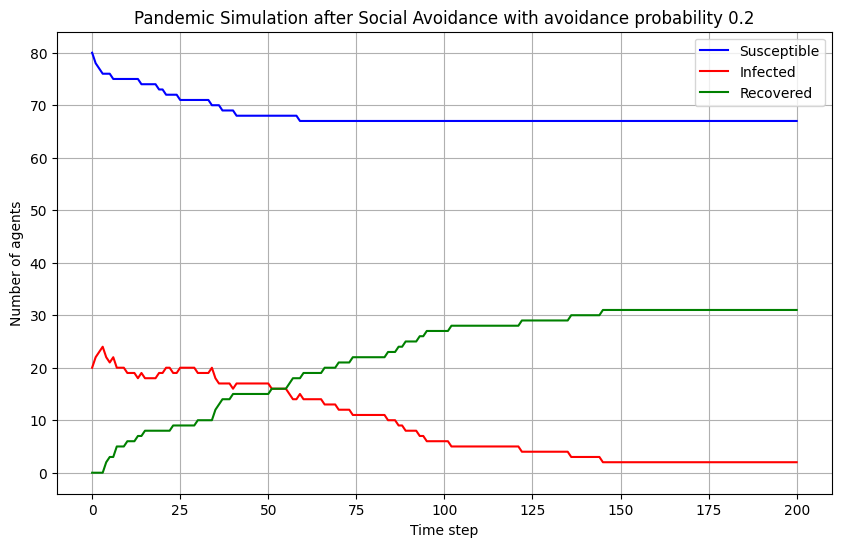

In [170]:
grid_h, grid_w = 25, 25
p = 0.9
q = 0.02
N = 100
size = 20
states, positions = initialize(seed = 1024, grid_w = grid_w, N = N, size = size)
pop_counts_avoid2 = simulate_avoid(states, positions, p = p, q = q, grid_h = grid_h, grid_w = grid_w, move_prob = 0.2)
plot2(pop_counts_avoid2, title = 'Pandemic Simulation after Social Avoidance with avoidance probability 0.2', p = p, q = q)

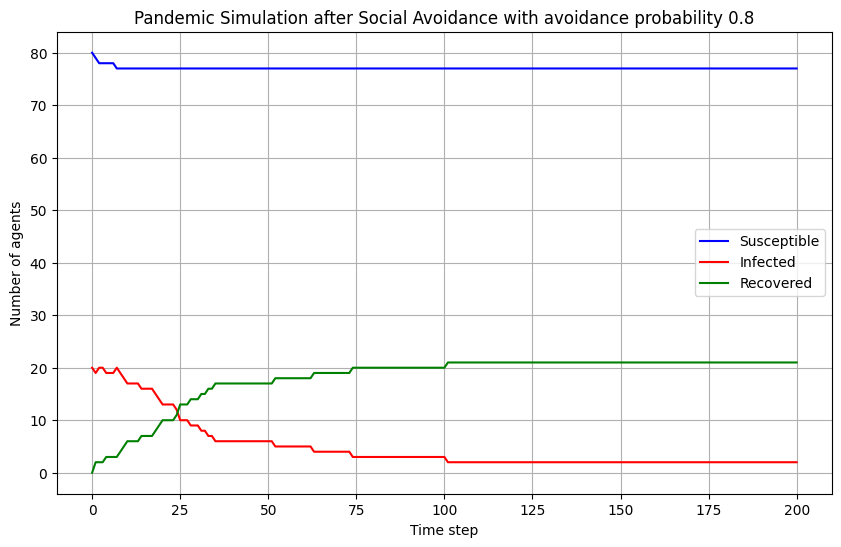

In [171]:
states, positions = initialize(seed = 1024, grid_w = grid_w, N = N, size = size)
pop_counts_avoid3 = simulate_avoid(states, positions, p = p, q = q, grid_h = grid_h, grid_w = grid_w, move_prob = 0.8)
plot2(pop_counts_avoid3, title = 'Pandemic Simulation after Social Avoidance with avoidance probability 0.8', p = p, q = q)

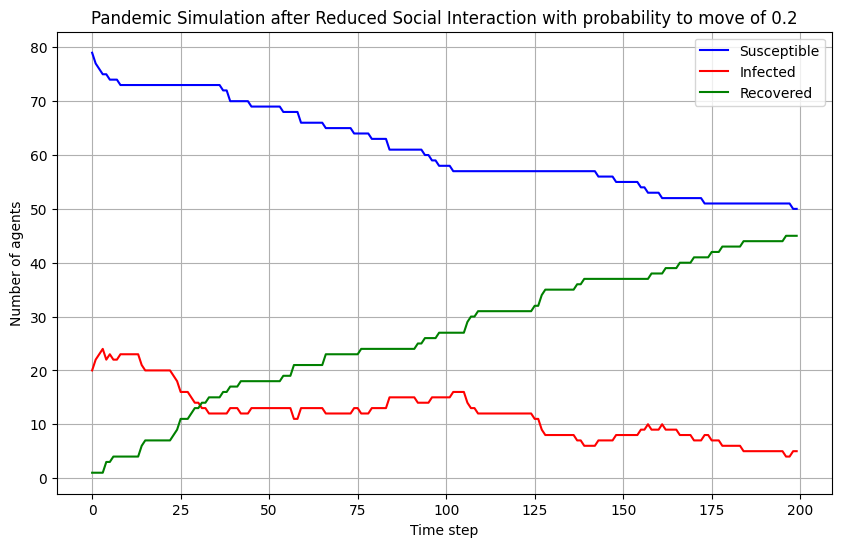

In [ ]:
states, positions = initialize(seed = 1024, grid_w = grid_w, N = N, size = size)
pop_counts_reduce2 = simulate_reduced(states, positions, p = p, q = q, grid_h = grid_h, grid_w = grid_w, move_prob = 0.2)
plot2(pop_counts_reduce2, title = 'Pandemic Simulation after Reduced Social Interaction with probability to move 0.2', p = p, q = q)

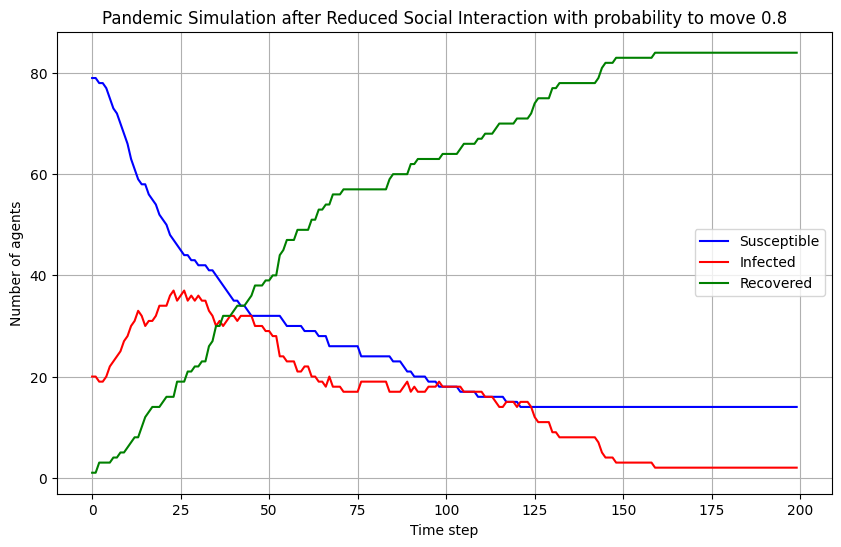

In [173]:
states, positions = initialize(seed = 1024, grid_w = grid_w, N = N, size = size)
pop_counts_reduce3 = simulate_reduced(states, positions, p = p, q = q, grid_h = grid_h, grid_w = grid_w, move_prob = 0.8)
plot2(pop_counts_reduce3, title = 'Pandemic Simulation after Reduced Social Interaction with probability to move 0.8', p = p, q = q)

- Reduced Social Interaction (Movement Probability)

Fig 14 (Move Probability 0.8): With a high 0.8 probability to move, the intervention is weak. The infection grows from its initial 20 agents to a significant new peak of approximately 37 agents around time step 35. This uncontrolled spread causes a rapid and large drop in the susceptible population, from 80 down to ~15.

Fig 15 (Move Probability 0.2): With a low 0.2 probability to move, the intervention is much stronger. It successfully flattens the curve by preventing a new infection peak; the infected curve (red) slowly declines from its starting point. This saves a large portion of the susceptible population, which only drops from 80 to ~50.

- Social Avoidance (Avoidance Probability)

Fig 16 (Avoidance Probability 0.2): With a low 0.2 probability of avoidance, the intervention is still quite effective. The infected curve shows no new peak and declines steadily from its start of ~24 agents. Some new transmission occurs, as the susceptible population drops from 80 to ~68, but the outbreak is largely contained.

Fig 17 (Avoidance Probability 0.8): With a high 0.8 probability of avoidance, the intervention is extremely effective and suppresses the outbreak almost immediately. The infected curve (red) drops sharply from its start of ~21 agents, with no new peak. Critically, the susceptible population barely moves (80 to ~77), and the recovered curve (green) levels off around ~21, indicating that almost no new infections occurred and only the initial infected group recovered.